## Data cleaning and exploration

### NASA GISS data
> The data are monthly observations in tabular format of temperature anomalies, i.e. **deviations from the corresponding 1951-1980 means**.
> Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies (Land-Ocean Temperature Index, LOTI)
[source](https://data.giss.nasa.gov/gistemp/)

#### The Elusive Absolute Surface Air Temperature (SAT)
> The GISTEMP analysis concerns only temperature anomalies, not absolute temperature. Temperature anomalies are computed relative to the base period 1951-1980. The reason to work with anomalies, rather than absolute temperature is that absolute temperature varies markedly in short distances, while monthly or annual temperature anomalies are representative of a much larger region. Indeed, we have shown (Hansen and Lebedeff, 1987) that temperature anomalies are strongly correlated out to distances of the order of 1000 km. ([source](https://data.giss.nasa.gov/gistemp/faq/abs_temp.html))

In [23]:
import locale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns

locale.setlocale(locale.LC_ALL, 'en_US')
sns.set()

# urls for fetching the csv
GLOBAL_MEANS_URL = "https://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.csv"
NORTHERN_MEANS_URL = "https://data.giss.nasa.gov/gistemp/tabledata_v3/NH.Ts+dSST.csv"
SOUTHERN_MEANS_URL = "https://data.giss.nasa.gov/gistemp/tabledata_v3/SH.Ts+dSST.csv"

In [24]:
# read data, skip first row as it contains the data set name
# Global-mean monthly, seasonal, and annual means, 1880-present, updated through most recent month
global_means = pd.read_csv(GLOBAL_MEANS_URL, skiprows=[0])

# Northern Hemisphere-mean monthly, seasonal, and annual means, 1880-present, updated through most recent month
northern_means = pd.read_csv(NORTHERN_MEANS_URL, skiprows=[0])

# southern Hemisphere-mean monthly, seasonal, and annual means, 1880-present, updated through most recent month
southern_means = pd.read_csv(SOUTHERN_MEANS_URL, skiprows=[0])

In [25]:
global_means.columns

Index(['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON'],
      dtype='object')

In [26]:
global_means.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.29,-.18,-.11,-.19,-.11,-.23,-.20,-.09,-.16,-.23,-.20,-.22,-.18,***,***,-.14,-.17,-.19
1,1881,-0.15,-.17,.04,.04,.02,-.20,-.06,-.02,-.14,-.21,-.22,-.11,-.10,-.11,-.18,.03,-.10,-.19
2,1882,0.14,.15,.04,-.19,-.16,-.26,-.21,-.05,-.10,-.25,-.16,-.24,-.11,-.10,.06,-.10,-.17,-.17
3,1883,-0.31,-.39,-.13,-.17,-.20,-.12,-.08,-.15,-.20,-.14,-.22,-.16,-.19,-.20,-.31,-.16,-.12,-.19
4,1884,-0.15,-.08,-.37,-.42,-.36,-.40,-.34,-.26,-.27,-.24,-.30,-.29,-.29,-.28,-.13,-.38,-.34,-.27


In [12]:
data_sets = {
    'global': global_means.copy(deep=True),
    'northern': northern_means.copy(deep=True),
    'southern': southern_means.copy(deep=True),
}

In [13]:
# tranform the data sets to a suitable form for visualization and modeling

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for key in data_sets:
    # unpivot the tabular data into a time series in long format
    data_sets[key] = data_sets[key].melt(id_vars=['Year'], var_name='Month', 
                                         value_vars=months, value_name=key)

    # convert the deviation values into numeric form
    # missing values seems to be represented with "***" these will be converted to NaNs
    data_sets[key][key] = pd.to_numeric(data_sets[key][key], errors='coerce')
    # Combine the year and month, and convert to datetime
    data_sets[key]['Date'] = pd.to_datetime(data_sets[key]['Year'].astype(str) + ' ' + data_sets[key]['Month'])
    # set the date as index
    data_sets[key].set_index('Date', inplace=True)
    data_sets[key].sort_index(inplace=True)

In [14]:
# apply exponential smoothing so we can see the long term patterns more easily
alpha = 0.03

for key in data_sets:
    data_sets[key]['%s_smoothed' % key] = data_sets[key][key].ewm(alpha=alpha).mean()

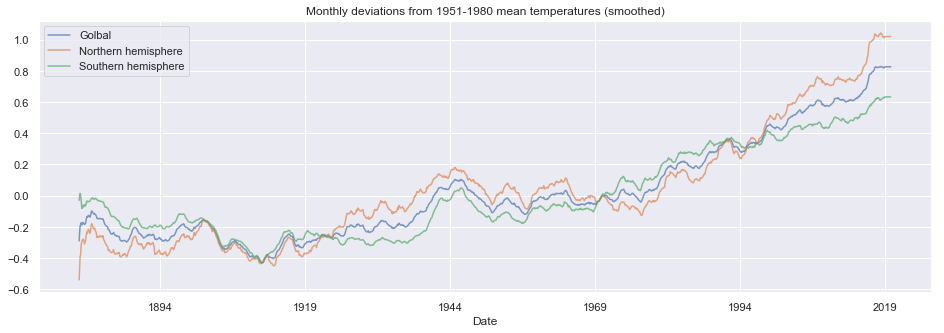

In [16]:
# plot the time series
labels = ['Golbal', 'Northern hemisphere', 'Southern hemisphere']

fig, ax = plt.subplots(figsize=(16, 5))

for key, label in zip(data_sets, labels):
    data_sets[key]['%s_smoothed' % key].plot(label=label, alpha=0.7)

_ = ax.set_title('Monthly deviations from 1951-1980 mean temperatures (smoothed)')
_ = ax.legend()

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


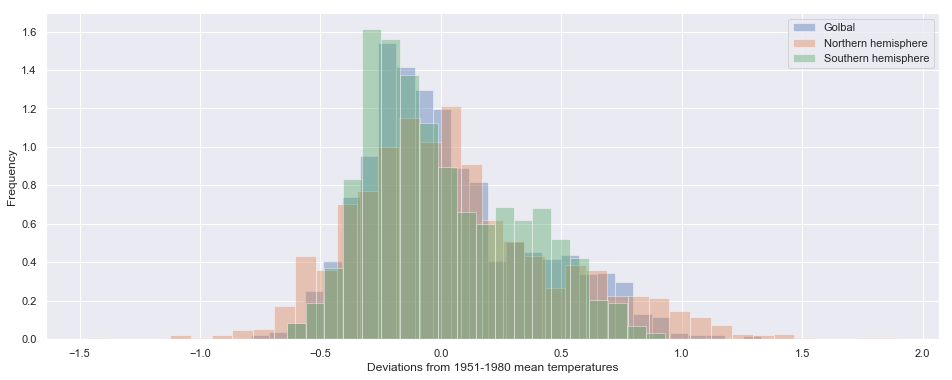

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))

labels = ['Golbal', 'Northern hemisphere', 'Southern hemisphere']

for key, label in zip(data_sets, labels):
    # fill missing values with mean
    mean = data_sets[key][key].mean()
    sns.distplot(data_sets[key][key].fillna(mean), 
                 kde=False,
                 norm_hist=True,
                 label=label, 
                 ax=ax)

ax.set_title('Distribution of values')
ax.set_alpha(0.5)
ax.set_xlabel('Deviations from 1951-1980 mean temperatures')
ax.set_ylabel('Frequency')
_ = ax.legend()

In [18]:
# combine data frames
monthly_deviations = pd.concat([data_sets[key][key] for key in data_sets], axis=1)

In [20]:
monthly_deviations.to_csv('../data/NASA_GISS_LOTI_long_format.csv')